# Curate Datasets

### Read the datasets and import the libraries

In [1]:
# Import our libraries
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="ticks")

%matplotlib inline

# Read in our dataset
mastercard = pd.read_csv('MasterCardData\GeoInsights_Synthetic_Output.csv')

# Take a look at the first few rows of the dataset
mastercard.head()

,txn_date,industry,quad_id,txn_amt,txn_cnt,acct_cnt,avg_ticket,avg_freq,avg_spend_amt,yoy_txn_amt,yoy_txn_cnt
0,2022-01-01,Total Retail,120230021323230,163.34,335.39,381.79,26.04,99.97,40.81,97.32,37.49
1,2022-01-01,Total Retail,120230023131110,400.82,474.70,462.13,120.85,104.33,106.34,-50.11,-75.64
2,2022-01-01,Eating Places,120230023131110,263.75,241.53,240.95,82.35,120.39,133.75,-31.29,-31.88
3,2022-01-01,Total Apparel,120230023131110,162.59,229.95,252.82,127.35,98.36,111.11,-16.39,-51.05
4,2022-01-01,Total Retail,120230210333222,171.27,128.84,131.45,425.06,100.94,429.76,212.50,-41.44


In [2]:
# Read in our dataset
geo_data = pd.read_csv('MasterCardData\GeoInsights_Hackathon_Quads_GeoInfo.csv', delimiter='|')
geo_data.head()

,quad_id,central_latitude,central_longitude,bounding_box
0,120230013313003,48.155093,13.991089,"POLYGON ((13.99658203125 48.15142814322122, 13..."
1,120230021330223,47.580231,12.496948,"POLYGON ((12.50244140625 47.57652571374621, 12..."
2,120230023133222,47.282955,12.573853,"POLYGON ((12.579345703125 47.27922900257082, 1..."
3,120230123333302,47.058896,15.430298,"POLYGON ((15.435791015625 47.05515408550347, 1..."
4,120221133132132,47.312759,11.145630,"POLYGON ((11.151123046875 47.30903424774781, 1..."


In [ ]:
# Perform the merge
merged_df = pd.merge(mastercard, geo_data, on='quad_id', how='inner')

# Now export the merged DataFrame to a CSV file
merged_df.to_csv('merged_dataset.csv', index=False)

### Get the quad_ids of the zones within a radius of the event locations

In [3]:
# Haversine formula to calculate distance between two lat-lon points
def haversine(lon1, lat1, lon2, lat2):
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert degrees to radians
    lon1_radians = np.radians(lon1)
    lat1_radians = np.radians(lat1)
    lon2_radians = np.radians(lon2)
    lat2_radians = np.radians(lat2)
    
    # Difference in coordinates
    dlon = lon2_radians - lon1_radians
    dlat = lat2_radians - lat1_radians
    
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_radians) * np.cos(lat2_radians) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distance in kilometers
    distance = R * c
    return distance

# Function to filter the dataset
def filter_by_radius(dataframe, event_location, radius):
    """
    dataframe: pandas DataFrame containing 'latitude' and 'longitude' columns
    event_location: tuple of (latitude, longitude) for the event location
    radius: radius in kilometers
    """
    # Apply the haversine function to each row in the dataframe
    distances = dataframe.apply(lambda row: haversine(event_location[1], event_location[0],
                                                      row['central_longitude'], row['central_latitude']), axis=1)
    
    # Filter the dataframe for rows where the distance is less than or equal to the radius
    return dataframe[distances <= radius]

In [4]:
# Calculate the middle point of Point A and Point B
def get_middlepoint(point_a, point_b):
    # Calculate the midpoint
    midpoint_longitude = (point_a[0] + point_b[0]) / 2
    midpoint_latitude = (point_a[1] + point_b[1]) / 2
    midpoint = (midpoint_longitude, midpoint_latitude)
    return midpoint

In [5]:
# Event coordinates
adidas_location = (47.169753170157186, 13.106657266616821)
snowboard_location = get_middlepoint((47.110209967822342, 13.132610321044922), (47.106588081374838, 13.122954368591309))
red_bull_location = get_middlepoint((47.112542887152543, 13.133828043937683), (47.115237117435001, 13.133377432823181))
ski_location = (47.062163427549223, 13.058323860168455)

In [6]:
ski_location

(47.06216342754922, 13.058323860168455)

In [7]:
# Filtered data
R = 1 # Radius in kilometers
ski_filtered_df = filter_by_radius(geo_data, ski_location, R)
snowboard_filtered_df = filter_by_radius(geo_data, snowboard_location, R)
red_bull_filtered_df = filter_by_radius(geo_data, red_bull_location, R)
adidas_filtered_df = filter_by_radius(geo_data, adidas_location, R)

In [8]:
adidas_filtered_df

,quad_id,central_latitude,central_longitude,bounding_box
1028,120230032303220,47.171044,13.101196,"POLYGON ((13.106689453125 47.16730970131577, 1..."
2019,120230032303223,47.163575,13.112183,"POLYGON ((13.11767578125 47.15984001304431, 13..."
2240,120230032303221,47.171044,13.112183,"POLYGON ((13.11767578125 47.16730970131577, 13..."
3169,120230032303222,47.163575,13.101196,"POLYGON ((13.106689453125 47.15984001304431, 1..."


### Filter the Mastercard data by time of the event

In [23]:
# Perform an inner join operation on the 'quad_id' column
ski_mastercard = mastercard[mastercard['quad_id'].isin(ski_filtered_df['quad_id'])]
snowboard_22_mastercard = mastercard[mastercard['quad_id'].isin(snowboard_filtered_df['quad_id'])]
snowboard_23_mastercard = mastercard[mastercard['quad_id'].isin(snowboard_filtered_df['quad_id'])]
adidas_mastercard = mastercard[mastercard['quad_id'].isin(adidas_filtered_df['quad_id'])]
red_bull_mastercard = mastercard[mastercard['quad_id'].isin(red_bull_filtered_df['quad_id'])]


In [24]:
ski_mastercard_time_filtered = ski_mastercard[(ski_mastercard['txn_date'] >= '2022-12-10') & (ski_mastercard['txn_date'] <= '2022-12-11')]
snowboard_22_mastercard_time_filtered = snowboard_22_mastercard[(snowboard_22_mastercard['txn_date'] >= '2022-01-11') & (snowboard_22_mastercard['txn_date'] <= '2022-01-12')]
snowboard_23_mastercard_time_filtered = snowboard_23_mastercard[(snowboard_23_mastercard['txn_date'] >= '2023-01-10') & (snowboard_23_mastercard['txn_date'] <= '2023-01-11')]
adidas_mastercard_time_filtered = adidas_mastercard[(adidas_mastercard['txn_date'] == '2022-09-10')]
red_bull_mastercard_time_filtered = red_bull_mastercard[(red_bull_mastercard['txn_date'] == '2023-02-10')]

In [26]:
ski_mastercard_year = ski_mastercard[(ski_mastercard['txn_date'] >= '2022-01-01') & (ski_mastercard['txn_date'] <= '2022-12-31')]
snowboard_22_mastercard_year = snowboard_22_mastercard[(snowboard_22_mastercard['txn_date'] >= '2022-01-01') & (snowboard_22_mastercard['txn_date'] <= '2022-12-31')]
snowboard_23_mastercard_year = snowboard_23_mastercard[(snowboard_23_mastercard['txn_date'] >= '2023-01-01') & (snowboard_23_mastercard['txn_date'] <= '2023-12-31')]
adidas_mastercard_year = adidas_mastercard[(adidas_mastercard['txn_date'] >= '2022-01-01') & (adidas_mastercard['txn_date'] <= '2022-12-31')]
red_bull_mastercard_year = red_bull_mastercard[(red_bull_mastercard['txn_date'] >= '2023-01-01') & (red_bull_mastercard['txn_date'] <= '2023-12-31')]

### Print expenditure of each day per year

In [27]:
# # Assuming 'df' is your DataFrame containing the dataset
ski_mastercard_year['txn_date'] = pd.to_datetime(ski_mastercard_year['txn_date'])
ski_mastercard_year = ski_mastercard_year.sort_values(by='txn_date', ascending=True)
ski_mastercard_year.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
snowboard_22_mastercard_year['txn_date'] = pd.to_datetime(snowboard_22_mastercard_year['txn_date'])
snowboard_22_mastercard_year = snowboard_22_mastercard_year.sort_values(by='txn_date', ascending=True)
snowboard_22_mastercard_year.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
snowboard_23_mastercard_year['txn_date'] = pd.to_datetime(snowboard_23_mastercard_year['txn_date'])
snowboard_23_mastercard_year = snowboard_23_mastercard_year.sort_values(by='txn_date', ascending=True)
snowboard_23_mastercard_year.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
adidas_mastercard_year['txn_date'] = pd.to_datetime(adidas_mastercard_year['txn_date'])
adidas_mastercard_year = adidas_mastercard_year.sort_values(by='txn_date', ascending=True)
adidas_mastercard_year.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
red_bull_mastercard_year['txn_date'] = pd.to_datetime(red_bull_mastercard_year['txn_date'])
red_bull_mastercard_year = red_bull_mastercard_year.sort_values(by='txn_date', ascending=True)
red_bull_mastercard_year.set_index('txn_date', inplace=True)

C:\Users\diego\AppData\Local\Temp\ipykernel_24780\212615515.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snowboard_22_mastercard_year['txn_date'] = pd.to_datetime(snowboard_22_mastercard_year['txn_date'])
C:\Users\diego\AppData\Local\Temp\ipykernel_24780\212615515.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snowboard_23_mastercard_year['txn_date'] = pd.to_datetime(snowboard_23_mastercard_year['txn_date'])
C:\Users\diego\AppData\Local\Temp\ipykernel_24780\212615515.py:17: SettingWithCopyWarni

In [20]:
# # Assuming 'df' is your DataFrame containing the dataset
adidas_mastercard_time_filtered['txn_date'] = pd.to_datetime(adidas_mastercard_time_filtered['txn_date'])
adidas_mastercard_time_filtered = adidas_mastercard_time_filtered.sort_values(by='txn_date', ascending=True)
adidas_mastercard_time_filtered.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
ski_mastercard_time_filtered['txn_date'] = pd.to_datetime(ski_mastercard_time_filtered['txn_date'])
ski_mastercard_time_filtered = ski_mastercard_time_filtered.sort_values(by='txn_date', ascending=True)
ski_mastercard_time_filtered.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
snowboard_22_mastercard_time_filtered['txn_date'] = pd.to_datetime(snowboard_22_mastercard_time_filtered['txn_date'])
snowboard_22_mastercard_time_filtered = snowboard_22_mastercard_time_filtered.sort_values(by='txn_date', ascending=True)
snowboard_22_mastercard_time_filtered.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
snowboard_23_mastercard_time_filtered['txn_date'] = pd.to_datetime(snowboard_23_mastercard_time_filtered['txn_date'])
snowboard_23_mastercard_time_filtered = snowboard_23_mastercard_time_filtered.sort_values(by='txn_date', ascending=True)
snowboard_23_mastercard_time_filtered.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
red_bull_mastercard_time_filtered['txn_date'] = pd.to_datetime(red_bull_mastercard_time_filtered['txn_date'])
red_bull_mastercard_time_filtered = red_bull_mastercard_time_filtered.sort_values(by='txn_date', ascending=True)
red_bull_mastercard_time_filtered.set_index('txn_date', inplace=True)

C:\Users\diego\AppData\Local\Temp\ipykernel_24780\2593739172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adidas_mastercard_time_filtered['txn_date'] = pd.to_datetime(adidas_mastercard_time_filtered['txn_date'])
C:\Users\diego\AppData\Local\Temp\ipykernel_24780\2593739172.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_bull_mastercard_time_filtered['txn_date'] = pd.to_datetime(red_bull_mastercard_time_filtered['txn_date'])


In [13]:
# # Assuming 'df' is your DataFrame containing the dataset
adidas_mastercard['txn_date'] = pd.to_datetime(adidas_mastercard['txn_date'])
adidas_mastercard = adidas_mastercard.sort_values(by='txn_date', ascending=True)
adidas_mastercard.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
ski_mastercard['txn_date'] = pd.to_datetime(ski_mastercard['txn_date'])
ski_mastercard = ski_mastercard.sort_values(by='txn_date', ascending=True)
ski_mastercard.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
snowboard_22_mastercard['txn_date'] = pd.to_datetime(snowboard_22_mastercard['txn_date'])
snowboard_22_mastercard = snowboard_22_mastercard.sort_values(by='txn_date', ascending=True)
snowboard_22_mastercard.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
snowboard_23_mastercard['txn_date'] = pd.to_datetime(snowboard_23_mastercard['txn_date'])
snowboard_23_mastercard = snowboard_23_mastercard.sort_values(by='txn_date', ascending=True)
snowboard_23_mastercard.set_index('txn_date', inplace=True)

# Assuming 'df' is your DataFrame containing the dataset
red_bull_mastercard['txn_date'] = pd.to_datetime(red_bull_mastercard['txn_date'])
red_bull_mastercard = red_bull_mastercard.sort_values(by='txn_date', ascending=True)
red_bull_mastercard.set_index('txn_date', inplace=True)

C:\Users\diego\AppData\Local\Temp\ipykernel_24780\819232058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adidas_mastercard['txn_date'] = pd.to_datetime(adidas_mastercard['txn_date'])
C:\Users\diego\AppData\Local\Temp\ipykernel_24780\819232058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snowboard_22_mastercard['txn_date'] = pd.to_datetime(snowboard_22_mastercard['txn_date'])
C:\Users\diego\AppData\Local\Temp\ipykernel_24780\819232058.py:17: SettingWithCopyWarning: 
A value is trying to be set

In [14]:
import matplotlib.pyplot as plt

def plot_features_per_quad(dataframe, feature_1, feature_2):
    # Get the unique quad_ids
    quad_ids = dataframe['quad_id'].unique()

    # Number of unique quad_ids
    num_quads = len(quad_ids)

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=num_quads, ncols=1, figsize=(10, 5 * num_quads))

    # If only one quad_id, axes may not be an array, so we wrap it in a list
    if num_quads == 1:
        axes = [axes]

    # Loop through each quad_id and plot on a separate subplot
    for i, quad_id in enumerate(quad_ids):
        # Filter the DataFrame for the current quad_id
        df_quad = dataframe[dataframe['quad_id'] == quad_id]

        # Plot feature 1 and feature 2 on the same subplot for the current quad_id
        ax = axes[i]
        df_quad[feature_1].plot(ax=ax, label=feature_1)
        df_quad[feature_2].plot(ax=ax, label=feature_2)

        # Set the title and legend for the subplot
        ax.set_title(f'Development of Features for quad_id {quad_id}')
        ax.legend()

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()


In [31]:
import matplotlib.pyplot as plt

def plot_MA_features_per_quad(dataframe, feature_1, feature_2):
    # Calculate the 10-day moving average for 'feature 1' and 'feature 2'
    dataframe['feature_1_10day_MA'] = dataframe[feature_1].rolling(window=15).mean()
    dataframe['feature_2_10day_MA'] = dataframe[feature_2].rolling(window=15).mean()
    
    # Get the unique quad_ids
    quad_ids = dataframe['quad_id'].unique()

    # Number of unique quad_ids
    num_quads = len(quad_ids)

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=num_quads, ncols=1, figsize=(10, 5 * num_quads))

    # If only one quad_id, axes may not be an array, so we wrap it in a list
    if num_quads == 1:
        axes = [axes]

    # Loop through each quad_id and plot on a separate subplot
    for i, quad_id in enumerate(quad_ids):
        # Filter the DataFrame for the current quad_id
        df_quad = dataframe[dataframe['quad_id'] == quad_id]

        # Plot feature 1 and feature 2 on the same subplot for the current quad_id
        ax = axes[i]
        df_quad['feature_1_10day_MA'].plot(ax=ax, label=feature_1)
        df_quad['feature_2_10day_MA'].plot(ax=ax, label=feature_2)

        # Set the title and legend for the subplot
        ax.set_title(f'Development of Features for quad_id {quad_id}')
        ax.legend()

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
# txn_amt	txn_cnt	acct_cnt	avg_ticket	avg_freq	avg_spend_amt

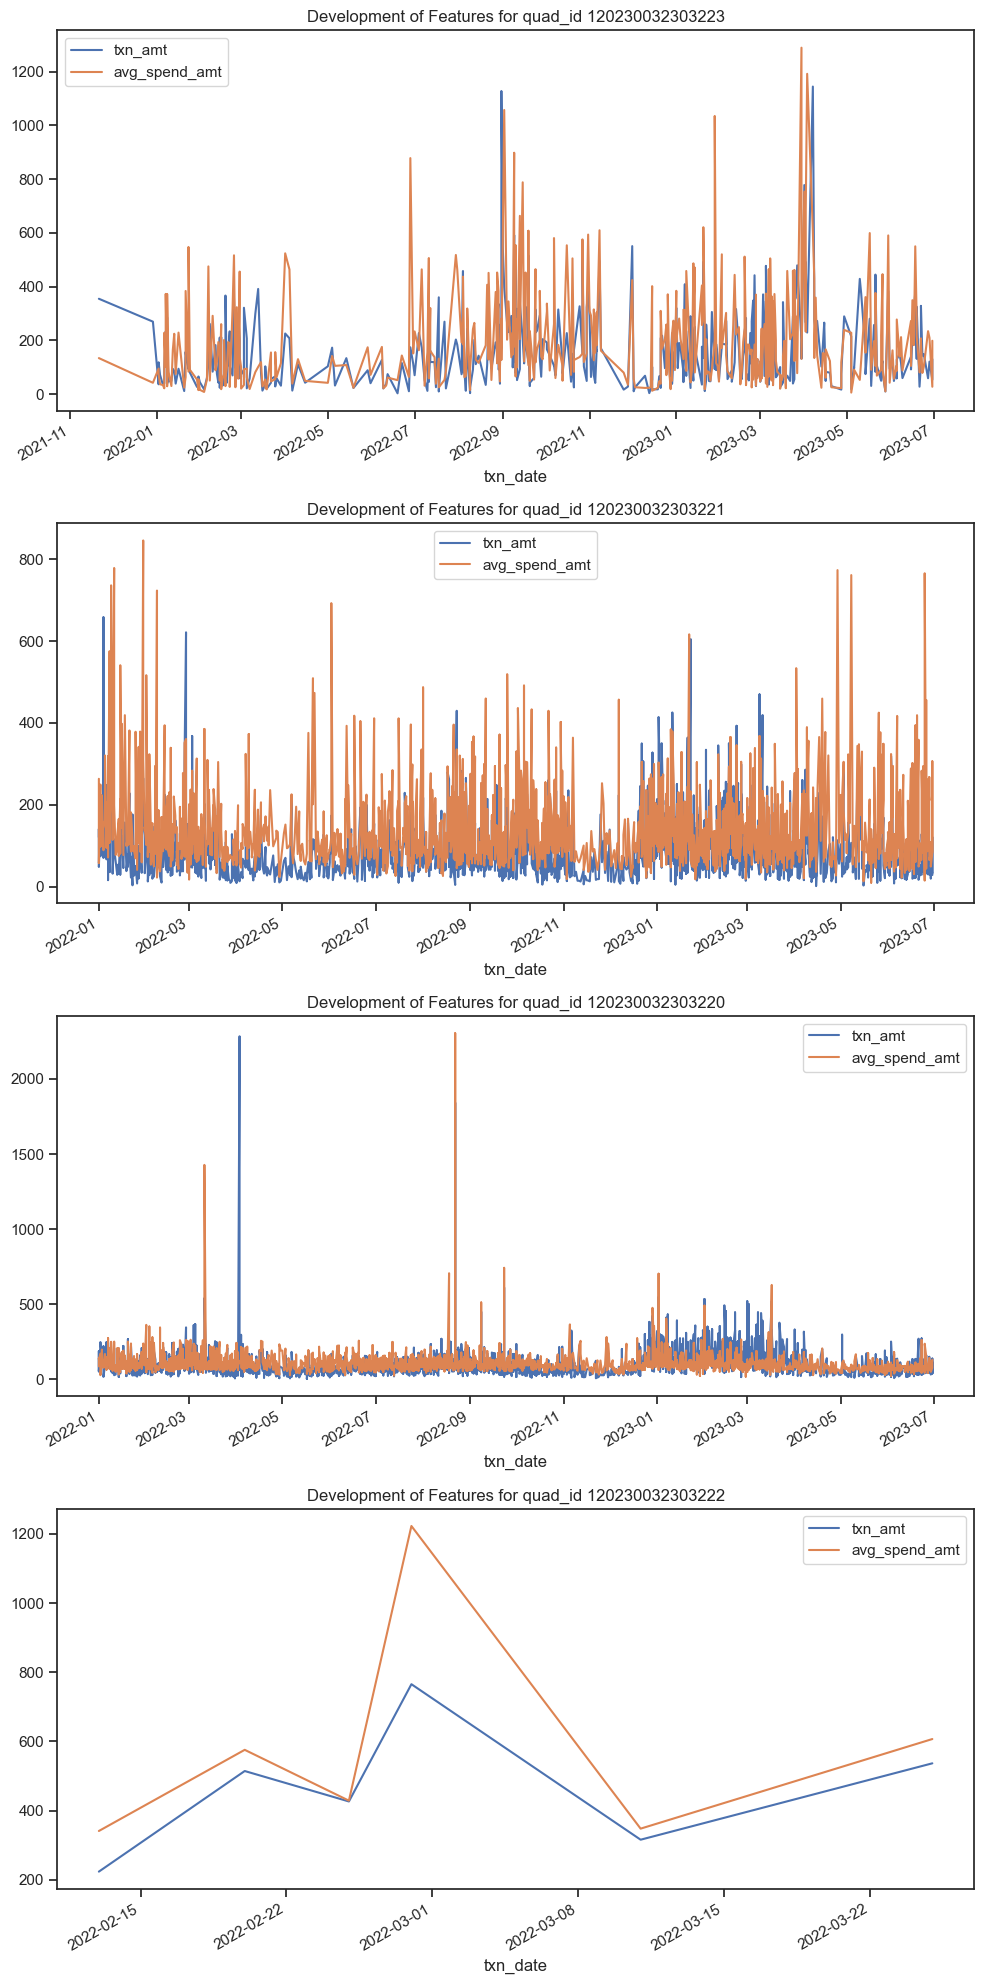

In [15]:
plot_features_per_quad(adidas_mastercard, "txn_amt", "avg_spend_amt")

C:\Users\diego\AppData\Local\Temp\ipykernel_24780\945429377.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['feature_1_10day_MA'] = dataframe[feature_1].rolling(window=15).mean()
C:\Users\diego\AppData\Local\Temp\ipykernel_24780\945429377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['feature_2_10day_MA'] = dataframe[feature_2].rolling(window=15).mean()


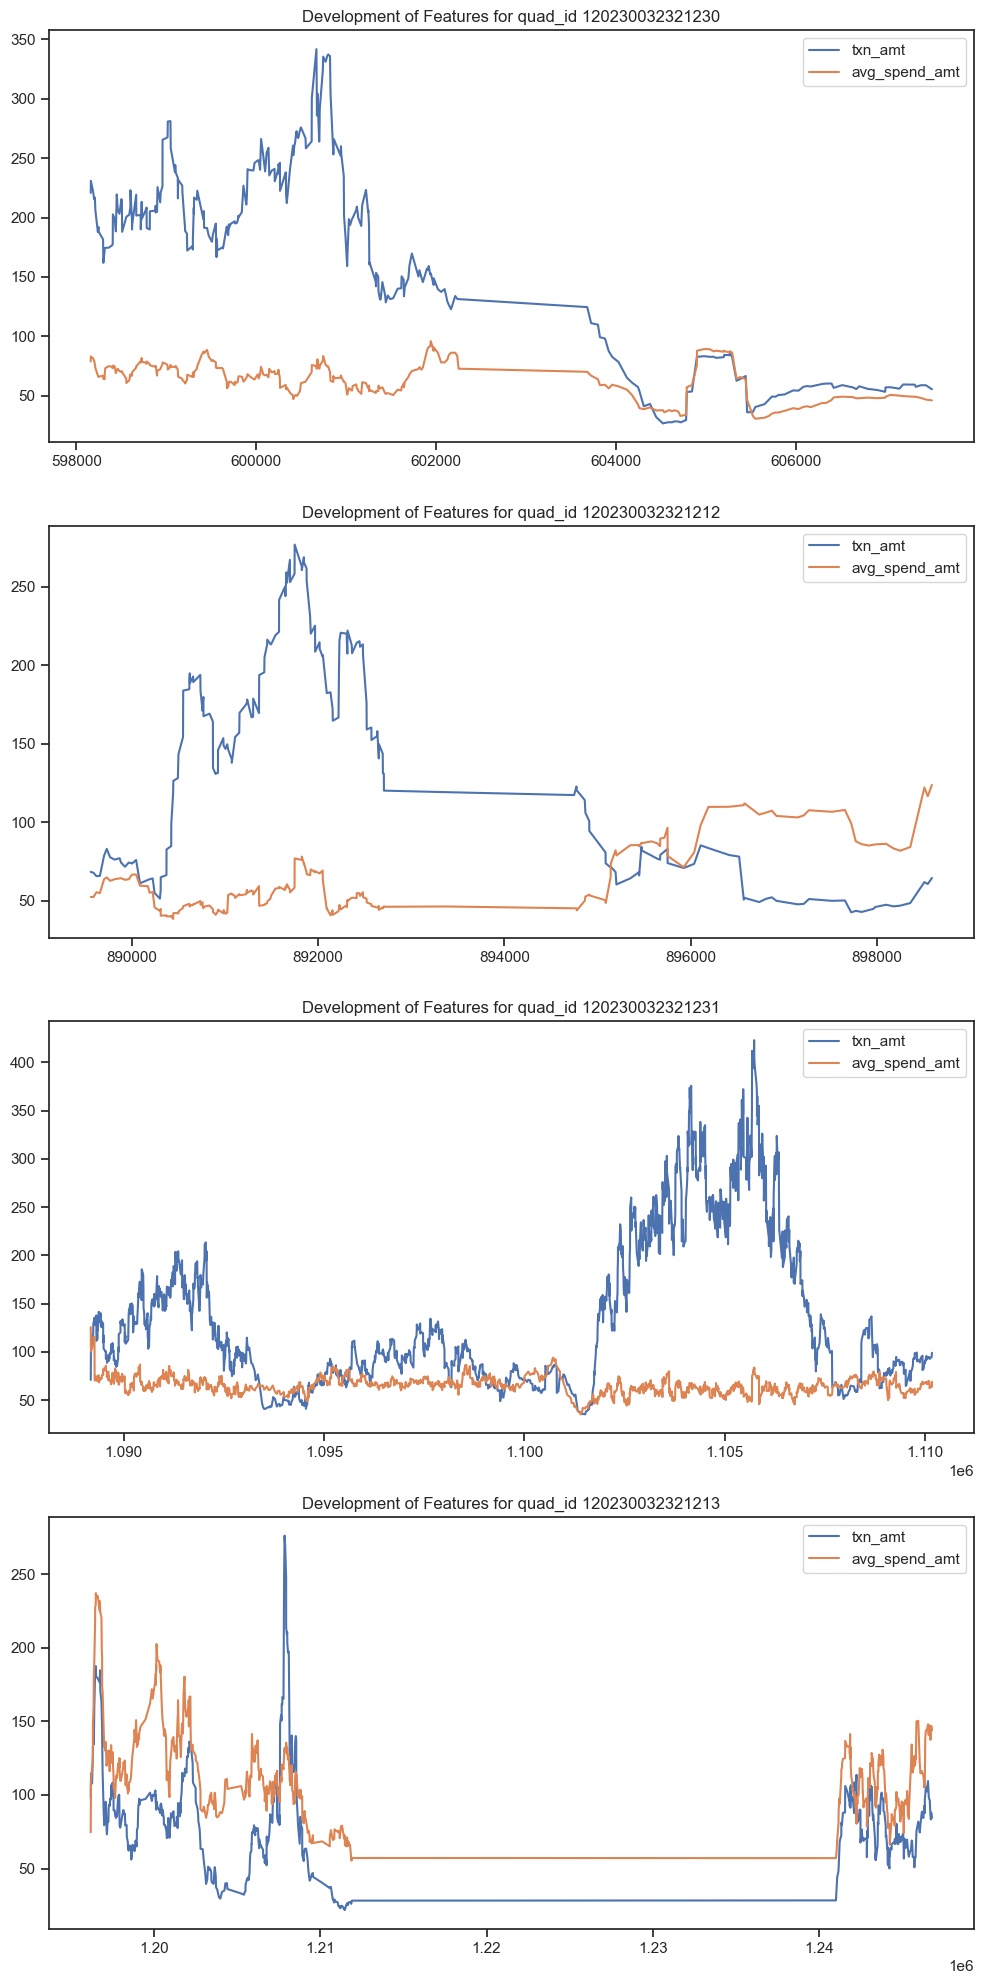

In [33]:
plot_MA_features_per_quad(red_bull_mastercard, "txn_amt", "avg_spend_amt")

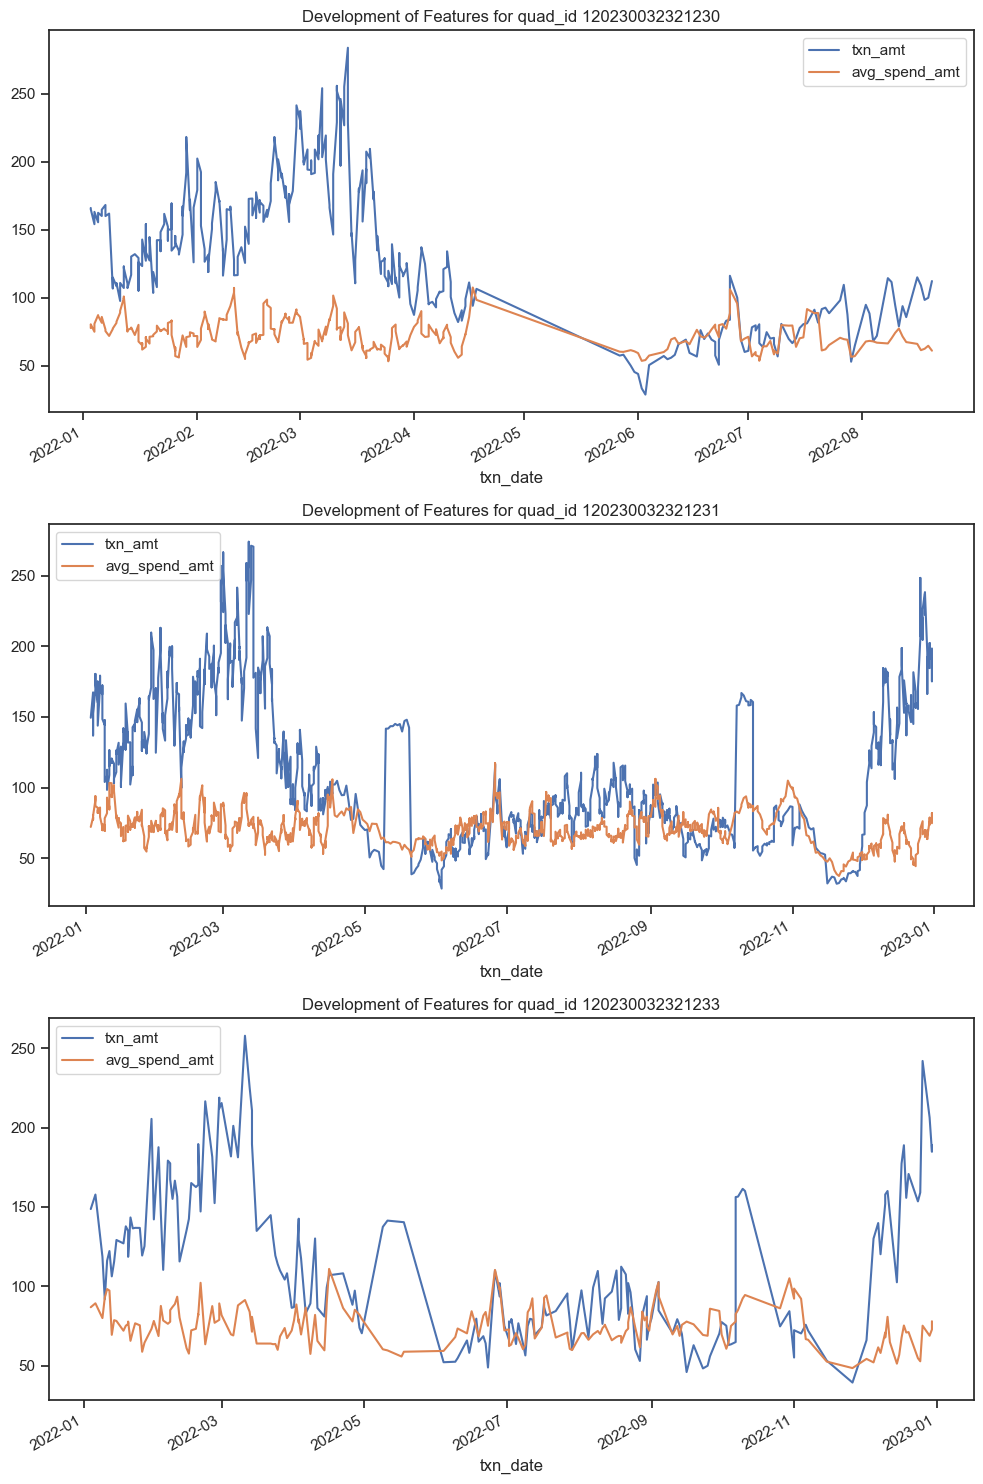

In [32]:
plot_MA_features_per_quad(snowboard_22_mastercard_year, "txn_amt", "avg_spend_amt")